# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

In [1]:
!pip install --upgrade scikit-learn
!pip install catboost
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 45.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
# utilizar: !pip install category_encoders (Si se requiere target encoding, para este proyecto no es necesario)
# utilizar: !pip install --upgrade scikit-learn (Actualizar Sklearn SI es necesario para este proyecto)
# Instalar catboost

# Para acceder a mi drive y los archivos
from google.colab import drive

# Manejo de datos
import pandas as pd
import numpy as np

# Optimizacion
import time

# Visualizacion
import seaborn as sns
from matplotlib import pyplot as plt

# Para series-tiempo
from statsmodels.tsa.seasonal import seasonal_decompose

# Preparacion y evaluacion de datos
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RandomForestRegressor Model
from sklearn.ensemble import RandomForestRegressor
# CatBoost Regression Model
from catboost import CatBoostRegressor
# XGBoostRegressor Model
from xgboost import XGBRegressor
# LightGBM Regression Model
from lightgbm import LGBMRegressor

In [3]:
drive.mount('/content/gdrive',force_remount=True)
ruta_1='/content/gdrive/MyDrive/Colab Notebooks/DATA TRIPLETEN/taxi.csv'

Mounted at /content/gdrive


In [4]:
df = pd.read_csv(ruta_1)
print(df.info())
display(df.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


,datetime,num_orders
0,2018-03-01 00:00:00,9


In [5]:
# Convertir a tipo datetime
df['datetime'] = pd.to_datetime(df['datetime'],yearfirst=1,format="%Y-%m-%d %H:%M:%S")
df = df.set_index('datetime',drop=1)

# Establecer la columna datetime como el indice y ordenar:
df = df.sort_index(ascending=1)
print(df.index.is_monotonic_increasing)

# Remuestrear a una hora:
df = df.resample('1H').sum().round()

True


/tmp/ipython-input-3903021473.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum().round()


In [6]:
# Mostrar la tendencia general y la media movil
datos = df.copy()
datos['rolling_mean_12'] = datos['num_orders'].shift(1).rolling(12).mean()
display(datos.head(1))

,num_orders,rolling_mean_12
datetime,,
2018-03-01,124,NaN


# Analysis

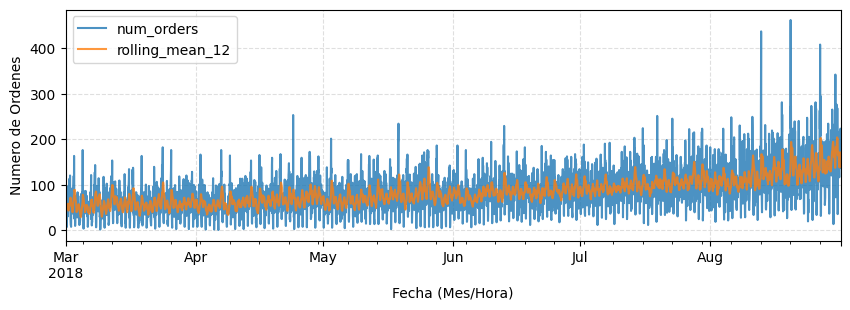

-- Tendencia de aumento en el numero de ordenes despues de Julio.


In [7]:
# Mostrar la tendencia para el numero de ordenes
datos[['num_orders','rolling_mean_12']].plot(figsize=(10,3),alpha=0.8)
plt.xlabel('Fecha (Mes/Hora)')
plt.ylabel('Numero de Ordenes')
plt.grid(alpha=0.4,linestyle='--')
plt.show()

print('-- Tendencia de aumento en el numero de ordenes despues de Julio.')

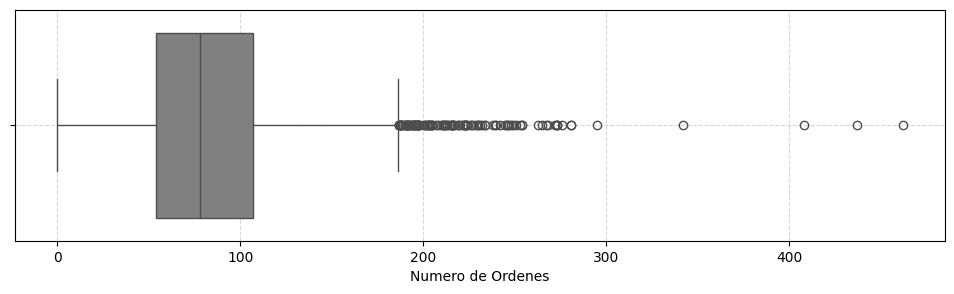

Gran cantidad de valores atipicos en el numero de ordenes, valor maximo: 462 y valor minimo: 0
num_orders
73     65
66     58
57     58
78     54
84     52
       ..
227     1
342     1
276     1
268     1
207     1
Name: count, Length: 251, dtype: int64


In [11]:
# Explorar outliers:
plt.figure(figsize=(12,3))
sns.boxplot(x=df['num_orders'],color='grey')
plt.xlabel('Numero de Ordenes')
plt.grid(alpha=0.5,linestyle='--')
plt.show()
maximo = df['num_orders'].max()
minimo = df['num_orders'].min()
print(f'Gran cantidad de valores atipicos en el numero de ordenes, valor maximo: {maximo} y valor minimo: {minimo}')
print(df['num_orders'].value_counts())

Existe una tendecia de aumento despues de Julio
Hay picos para cada cambio de hora y valles cada ≈ 15 min despues del cambio de hora
Para este ejemplo: Marzo 2018
Se muestra una tendencia de 50 ordenes con una estacionalidad de ≈ +50 y -50 segun el minuto
Ordenes - Momento de valle ≈ 0
Ordenes - Momento pico ≈ 100


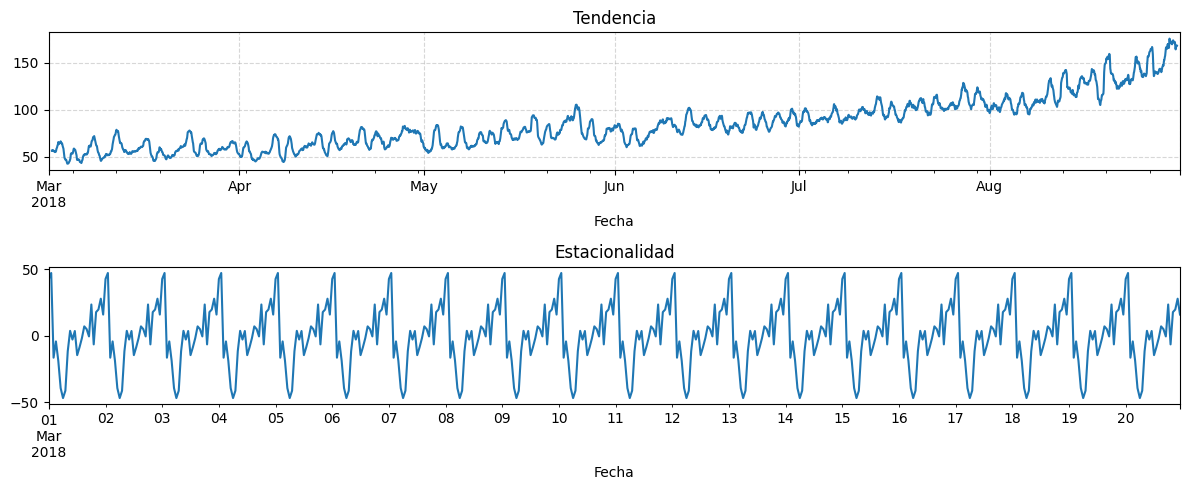

In [12]:
# Para una mejor vista de la estacionalidad reducire el numero de observaciones:
corte = df['2018-01-01':'2018-03-20']

decompose2 = seasonal_decompose(corte['num_orders'])
decompose1 = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(12,5))
plt.subplot(211)
decompose1.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.xlabel('Fecha')
plt.grid(alpha=0.5,linestyle='--')
plt.subplot(212)
decompose2.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.xlabel('Fecha')
plt.tight_layout()

print('Existe una tendecia de aumento despues de Julio')
print('Hay picos para cada cambio de hora y valles cada ≈ 15 min despues del cambio de hora')
print('Para este ejemplo: Marzo 2018')
print('Se muestra una tendencia de 50 ordenes con una estacionalidad de ≈ +50 y -50 segun el minuto')
print('Ordenes - Momento de valle ≈ 0')
print('Ordenes - Momento pico ≈ 100')

In [13]:
# Evaluar la media y mediana de los datos antes de pasar al modelo de referencia:
mediana = df['num_orders'].median()
media = df['num_orders'].mean()
print(f'Mediana para el numero de ordenes: {mediana:.2f}')
print()
print(f'Media para el numero de ordenes: {media:.2f}')
print()
print('Ambas metricas de localidad son cercanas.')
print('Sin embargo acercare ligeramente la media a la mediana dado que la metrica de evaluacion es RSME la cual es sensible a outliers.')
print()

# Tratamiento diminuto de outliers basado en el boxplot
data = df.copy()
data = data[data['num_orders'] < 300]
print(data.shape)

Mediana para el numero de ordenes: 78.00

Media para el numero de ordenes: 84.42

Ambas metricas de localidad son cercanas.
Sin embargo acercare ligeramente la media a la mediana dado que la metrica de evaluacion es RSME la cual es sensible a outliers.

(4412, 1)


# Formacion

In [14]:
# Crear datos de entrenamiento y prueba
def lags_y_media_movil(data, max_lag, rolling_mean_size):

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean_{}'.format(rolling_mean_size)] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean() # Aqui el shift() para desfazar la media movil ultima y evitar el leakage para esa prediccion
    )
    return data

# Columnas de tiempo
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour

# Lags y Media Movil suavizada a 12 horas
data = lags_y_media_movil(data,12,12)

train, test = train_test_split(data,test_size=0.1,shuffle=False)
train = train.dropna()

x_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']

x_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

display(train.head(1))
display(test.tail(1))
print()
print(f'Datos Entrenamiento no mezclados: {train.shape}')
print(train.index.min(), train.index.max())
print()
print(f'Datos Prueba no mezclados {test.shape}')
print(test.index.min(), test.index.max())

,num_orders,year,month,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean_12
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,30,2018,3,1,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,57.083333


,num_orders,year,month,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean_12
datetime,,,,,,,,,,,,,,,,,,
2018-08-31 23:00:00,205,2018,8,31,23,223.0,159.0,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,167.583333



Datos Entrenamiento no mezclados: (3958, 18)
2018-03-01 12:00:00 2018-08-13 10:00:00

Datos Prueba no mezclados (442, 18)
2018-08-13 11:00:00 2018-08-31 23:00:00


In [15]:
# Prediccion dummy (ultimo valor del set de entrenamiento como la prediccion)
dummy = df.copy()
dummy_train, dummy_test = train_test_split(dummy,test_size=0.1,shuffle=False)
dummy_test_median = np.median(dummy_test['num_orders'])
print(f'Mediana para el numero de ordenes totales en el conjunto de prueba dummy: {round(dummy_test_median)}')

pred_previous = dummy_test.shift()
pred_previous.iloc[0] = dummy_train.iloc[-1]
print('RMSE:', round(np.sqrt(mean_squared_error(dummy_test,pred_previous))))

Mediana para el numero de ordenes totales en el conjunto de prueba dummy: 135
RMSE: 59


In [16]:
def evaluar(y,a):
    print(f'RMSE: {round(np.sqrt(mean_squared_error(y,a)))}')

# Prueba

In [17]:
estimators = [20,40,60,80,100]
for e in estimators:
    modelo_1 = XGBRegressor(objective='reg:squarederror',random_state=1,n_estimators=e,max_depth=5)
    print(f'Modelo con {e} estimadores')
    start = time.time()
    modelo_1.fit(x_train,y_train)
    end = time.time()
    print(f'Tiempo de entrenamiento: {end-start}')
    prediccion_1 = modelo_1.predict(x_test)
    evaluar(y_test,prediccion_1)
    print('*')
# Este modelo obtuvo el mismo puntaje que la prediccion dummy.

Modelo con 20 estimadores
Tiempo de entrenamiento: 0.4103107452392578
RMSE: 43
*
Modelo con 40 estimadores
Tiempo de entrenamiento: 0.1468029022216797
RMSE: 42
*
Modelo con 60 estimadores
Tiempo de entrenamiento: 0.13452672958374023
RMSE: 42
*
Modelo con 80 estimadores
Tiempo de entrenamiento: 0.17123818397521973
RMSE: 42
*
Modelo con 100 estimadores
Tiempo de entrenamiento: 0.23334598541259766
RMSE: 42
*


In [18]:
iteraciones = [50,100,150,200,220]
for i in iteraciones:
    modelo_2 = CatBoostRegressor(iterations=i,loss_function='RMSE',random_state=1)
    print(f'Modelo con {i} iteraciones')
    start = time.time()
    modelo_2.fit(x_train,y_train,verbose=50)
    end = time.time()
    print(f'Tiempo de entrenamiento: {end-start}')
    prediccion_2 = modelo_2.predict(x_test)
    evaluar(y_test,prediccion_2)
    print('*')
# Este modelo mejoro a un error de 57 ordenes, pero aun por encima de 48 que es el umbral deseado.

Modelo con 50 iteraciones
Learning rate set to 0.5
0:	learn: 29.9861772	total: 87.8ms	remaining: 4.3s
49:	learn: 16.4471733	total: 439ms	remaining: 0us
Tiempo de entrenamiento: 0.5378274917602539
RMSE: 43
*
Modelo con 100 iteraciones
Learning rate set to 0.330812
0:	learn: 32.3864263	total: 12.9ms	remaining: 1.27s
50:	learn: 18.0638196	total: 350ms	remaining: 336ms
99:	learn: 14.9078531	total: 659ms	remaining: 0us
Tiempo de entrenamiento: 0.7124559879302979
RMSE: 40
*
Modelo con 150 iteraciones
Learning rate set to 0.237913
0:	learn: 33.8942825	total: 3.77ms	remaining: 562ms
50:	learn: 18.9668619	total: 180ms	remaining: 350ms
100:	learn: 16.3156473	total: 348ms	remaining: 169ms
149:	learn: 14.5283617	total: 542ms	remaining: 0us
Tiempo de entrenamiento: 0.5918788909912109
RMSE: 40
*
Modelo con 200 iteraciones
Learning rate set to 0.188297
0:	learn: 34.7469608	total: 3.71ms	remaining: 739ms
50:	learn: 19.5383342	total: 170ms	remaining: 498ms
100:	learn: 17.1603066	total: 361ms	remaining:

In [19]:
estimadores = [25,50,100,150,200,250]
for e in estimadores:
    modelo_3 = LGBMRegressor(metric='rmse',boosting_type='gbdt',n_estimators = e,objective ='regression',random_state=1)
    print(f'Modelo con {e} estimadores.')
    start = time.time()
    modelo_3.fit(x_train,y_train)
    end = time.time()
    print(f'Tiempo de entrenamiento: {end-start}')
    prediccion_3 = modelo_3.predict(x_test)
    evaluar(y_test,prediccion_3)
    print('*')

Modelo con 25 estimadores.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2596
[LightGBM] [Info] Number of data points in the train set: 3958, number of used features: 16
[LightGBM] [Info] Start training from score 78.233957
Tiempo de entrenamiento: 0.25115203857421875
RMSE: 44
*
Modelo con 50 estimadores.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2596
[LightGBM] [Info] Number of data points in the train set: 3958, number of used features: 16
[LightGBM] [Info] Start training from score 78.233957
Tiempo de entrenamiento: 0.1783313751220703
RMSE: 40
*
Modelo con 100 estimadores.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, t

In [20]:
estimators = [10,15,25,50,100,150,200,300]
for e in estimators:
    modelo_4 = RandomForestRegressor(
        random_state=1,
        n_estimators=e
    )
    print(f'Modelo con: {e} estimadores')
    start = time.time()
    modelo_4.fit(x_train,y_train)
    end = time.time()
    print(f'Tiempo de entrenamiento: {end-start}')
    prediccion_4 = modelo_4.predict(x_test)
    evaluar(y_test,prediccion_4)
    print()

Modelo con: 10 estimadores
Tiempo de entrenamiento: 1.4769792556762695
RMSE: 38

Modelo con: 15 estimadores
Tiempo de entrenamiento: 2.5321691036224365
RMSE: 38

Modelo con: 25 estimadores
Tiempo de entrenamiento: 2.076395273208618
RMSE: 39

Modelo con: 50 estimadores
Tiempo de entrenamiento: 2.881974697113037
RMSE: 38

Modelo con: 100 estimadores
Tiempo de entrenamiento: 5.811496257781982
RMSE: 39

Modelo con: 150 estimadores
Tiempo de entrenamiento: 11.656570196151733
RMSE: 39

Modelo con: 200 estimadores
Tiempo de entrenamiento: 12.54581594467163
RMSE: 39

Modelo con: 300 estimadores
Tiempo de entrenamiento: 18.598330974578857
RMSE: 39




# Conclusion:
1. Todos los modelos de regresion superaron exitosamente el umbral deseado y al modelo dummy.
2. Basado en el boxplot, se eliminaron valores mayores a 300 taxis dado que solo 4 observaciones superaron este numero y a pesar de ser picos de analisis, ellos actuan como ruido al momento de entrenar los modelos los cuales ven afectada la prediccion.
3. El recorte no fue considerado un patron de prediccion dado que observando la tendencia y la estacionalidad se obtiene un aproximado de ≈ 200 taxis a partir de Julio, esto es mucho menor a los picos de 300 y 400, incluso se podria considerar la posibilidad de un error al registrar estas cantidades o en el mejor de los casos una hora con un evento muy particular.
4. El mejor puntaje fue de un error de ordenes de $(38)$ taxis.
5. El mejor modelo fue XGBRegressor con 0.5 segundos seguido por CatBoostRegressor con un tiempo de entrenamiento de 0.7, en contraste con el tercer mejor puntaje de RandomForestRegressor el cual ocupa 1.21 segundos para alcanzar el mimso puntaje.
6. *EL MEJOR MODELO ES XGBRegressor, optimizado y preciso utilizando $40$ estimadores.*